#**Sound Classification**

**Target**:
Classification of 30s long audio files into speech or music.

**Guidance**:

1. create 64 time-samples long patches with overlap of 32 from all music and speach files. assign labels accordingly
2. build a classifier net, (e.g. 4 convolutional layers, use stride of 2; and 2 fully connected layers).
  - try different activation functions (relu, tanh, sigmoid).
3. Train on 80% of the data and validate on remaining 20
4. Study the convergence.

### Packages and functions

In [ ]:
# Load packages
import os
import pandas as pd
import numpy as np
from google.colab import drive
import time
import datetime
import random 
import seaborn as sns
from IPython.display import Audio
from collections import Counter

drive.mount('content/')

Mounted at content/


In [ ]:
# Provided functions

import matplotlib.pyplot as plt
from scipy.signal import hann
from scipy.io import wavfile
from scipy.io import wavfile

from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
	
def get_mag_phs(re, im):
	return np.sqrt(re**2 + im**2), np.angle(re + im * 1j)

def get_r_i(mag, phs):
	return mag * np.cos(phs), mag * np.sin(phs)


def load_wav(filename):
	_, w = wavfile.read(filename)
	w = w.astype(np.float32)
	norm = np.max(np.abs(w))
	w = w / norm
	w -= np.mean(w)
	return w
	

def dft(signal, step_size=256, fft_size=512):
	n_steps = len(signal) // step_size
	s = []
	hann_win = hann(fft_size)
	for hop_i in range(n_steps):
		frame = signal[(hop_i * step_size):(hop_i * step_size + fft_size)]
		frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
		frame *= hann_win
		s.append(frame)
	s = np.array(s)
	N = s.shape[-1]
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
	x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
	freqs = np.dot(x, k)
	reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
	imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
	return reals, imags


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal


##Data preparation

Procedure:
- Get directory of each audio file
- Split each category into train and test set since it is important that all slices from a single audio file are either train or test (overlapping)
- Load each audio
- Transform and slice into smaller steps
- Add labels

64 64
(661500,)


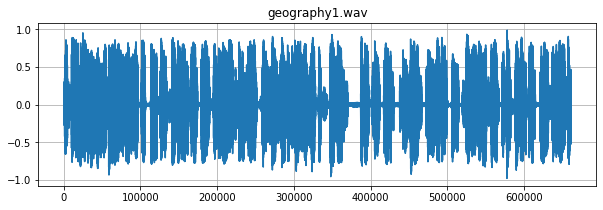

(661500,)


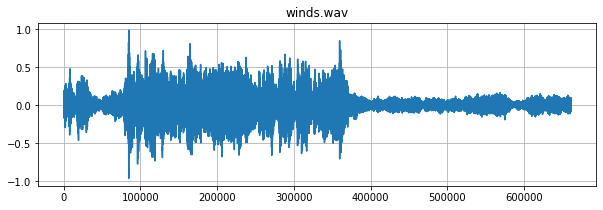

(256, 2583)


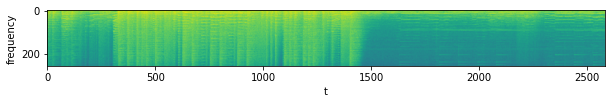

In [ ]:
music_dir = os.path.join('content/MyDrive/Projekt/M6/extract_files/Assignments/Speech_Music/speech_music_files/gtzan_music_speech/music_speech', 'music_wav')
music = [os.path.join(music_dir, file_i) for file_i in os.listdir(music_dir) if file_i.endswith('.wav')]

# Similarly, for the speech folder:
speech_dir = os.path.join('content/MyDrive/Projekt/M6/extract_files/Assignments/Speech_Music/speech_music_files/gtzan_music_speech/music_speech', 'speech_wav')
speech = [os.path.join(speech_dir, file_i) for file_i in os.listdir(speech_dir) if file_i.endswith('.wav')]
		  
print (len(music), len(speech))

music_file = speech[0]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[128:])
plt.show()

music_file = music[0]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[127:])
plt.show()

re, im = dft(mus0)
mag, phs = get_mag_phs(re, im)
mag = mag.T #transpose
magl = np.log(mag)
print(mag.shape)
plt.figure(figsize=(10, 3))
plt.imshow(magl)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()


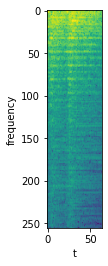

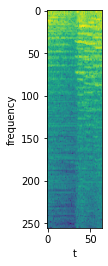

In [ ]:
plt.imshow(magl[:,0:64])
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

plt.imshow(magl[:,32:96])
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [ ]:
Audio('content/MyDrive/Projekt/M6/extract_files/Assignments/Speech_Music/speech_music_files/gtzan_music_speech/music_speech/speech_wav/dialogue.wav')

In [ ]:
Audio('content/MyDrive/Projekt/M6/extract_files/Assignments/Speech_Music/speech_music_files/gtzan_music_speech/music_speech/music_wav/gravity.wav')

In [ ]:
# Split each audio file into train and test

n_half = len(music)

random.shuffle(music)
random.shuffle(speech)

# split training and validation
# We will take 80% from each for training and 20 for validation
n_train_half = n_half*80//100
n_train = n_train_half*2

music_train = music[:n_train_half] # first 80 %
music_validation = music[n_train_half:] # remaining part

speech_train = speech[:n_train_half] # first 80 %
speech_validation = speech[n_train_half:] # remaining part

print(f'Music train: {len(music_train)}')
print(f'Speech train: {len(speech_train)}')
print(f'Music valid: {len(music_validation)}')
print(f'Speech valid: {len(speech_validation)}')

Music train: 51
Speech train: 51
Music valid: 13
Speech valid: 13


In [ ]:
# generate smaller samples from each audio file according to train and test
# put together speech and music

y_train = []
x_train = []
y_valid = []
x_valid = []
audio_path_train = []
audio_path_valid = []
audio_name_train = []
audio_name_valid = []

# Music train
for audio in music_train:
  mus0 = load_wav(audio)
  name_audio = audio[127:]
  re, im = dft(mus0)
  mag, phs = get_mag_phs(re, im)
  mag = mag.T #transpose
  magl = np.log(mag)
  n_steps = magl.shape[-1] // 32
  for i in range(n_steps - 1):
    magl_temp = magl[:,(i*32):(i*32 + 64)]
    x_train.append(magl_temp)
    y_train.append([1,0])  
    audio_name_train.append(name_audio)
    audio_path_train.append(audio)

# Music validation
for audio in music_validation:
  mus0 = load_wav(audio)
  name_audio = audio[127:]
  re, im = dft(mus0)
  mag, phs = get_mag_phs(re, im)
  mag = mag.T #transpose
  magl = np.log(mag)
  n_steps = magl.shape[-1] // 32
  for i in range(n_steps - 1):
    magl_temp = magl[:,(i*32):(i*32 + 64)]
    x_valid.append(magl_temp)
    y_valid.append([1,0])
    audio_name_valid.append(name_audio)
    audio_path_valid.append(audio)

# Speech train
for audio in speech_train:
  mus0 = load_wav(audio)
  name_audio = audio[128:]
  re, im = dft(mus0)
  mag, phs = get_mag_phs(re, im)
  mag = mag.T #transpose
  magl = np.log(mag)
  n_steps = magl.shape[-1] // 32
  for i in range(n_steps - 1):
    magl_temp = magl[:,(i*32):(i*32 + 64)]
    x_train.append(magl_temp)
    y_train.append([0,1]) 
    audio_name_train.append(name_audio) 
    audio_path_train.append(audio)       

# Speech validation
for audio in speech_validation:
  mus0 = load_wav(audio)
  name_audio = audio[128:]  
  re, im = dft(mus0)
  mag, phs = get_mag_phs(re, im)
  mag = mag.T #transpose
  magl = np.log(mag)
  n_steps = magl.shape[-1] // 32
  for i in range(n_steps - 1):
    magl_temp = magl[:,(i*32):(i*32 + 64)]
    x_valid.append(magl_temp)
    y_valid.append([0,1]) 
    audio_name_valid.append(name_audio)
    audio_path_valid.append(audio)        

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_valid.shape)
print(len(speech_train))
print(len(speech_validation))
print(f'Samples per audio file: {n_steps - 1}')

(8058, 256, 64)
(8058, 2)
(2054, 2)
51
13
Samples per audio file: 79


In [ ]:
# Need to change input dimension
x_train_2d = x_train.copy()
x_train = x_train_2d[..., np.newaxis] 

x_valid_2d = x_valid.copy()
x_valid = x_valid_2d[..., np.newaxis] 

##Model building


##### Comments

In [ ]:
# Remarks: 
# Kernel = Filter
# Strude = By how much the kernel moves (2 means every two pixels)
# Padding: same  <> input size = output size
#          valid <> no padding is done, so the output shrinks

# -> Would be interesting, what option leads to which size
# Conv2D
# > Stride = 2 halfs the input size (256 / 64) -> (128 / 32)
#   - Makes sense since every second pixcel is convolved
# > kernel_size has no impact on size

# MaxPooling2D
# > Stride = 2 halfs again the dimensions
# > pool_size * 2 does not half shape rather than reducing each by one (most likely due to padding)

# > Pooling need some dimensions else it does make no sense
# --> guess, if not a large 2d space, pooling does not make sense (e.g. last layers...)


####Model 1
- 4 Convolutional Layers
- 2 Fully Connected Layers
- Batch size 10
- 30 epochs

Testing:
- Activation functions ReLU and tanh for hidden layers
- Stride in (2,3) for Pooling and Conv-Layer
- Filter in (2,3)
- Learing rate in (0.001, 0.0005)

Adaptions are made manually instead of a grid search

In [ ]:

model = tf.keras.models.Sequential([
    # 1st Convolutional Layer strides = (2,2), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides = (2,2), activation ='relu', padding='same', input_shape=(256, 64, 1)),
    # 1st Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 2nd Convolutional Layer strides = (2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation = 'relu', padding='same'),
    # 2nd Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 3rd Convolutional Layer    
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation = 'relu', padding='same'),
    # 3rd Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 4th Convolutional Layer    
    tf.keras.layers.Conv2D(filters=256, kernel_size=2 ,activation = 'relu', padding='same'),
    # 4th Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),            
    # Flatten Layer
    tf.keras.layers.Flatten(),
    # First Fully Connected Layer
    tf.keras.layers.Dense(units=512, activation= 'relu'),
    # Second Fully Connected Layer
    tf.keras.layers.Dense(units=2, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005,),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
hist = model.fit(x_train, y_train, 
          epochs=30, 
          batch_size=10, 
          validation_data=(x_valid, y_valid))



In [ ]:
hist_compare = model.fit(x_train, y_train, 
          epochs=30, 
          batch_size=10, 
          validation_data=(x_valid, y_valid))

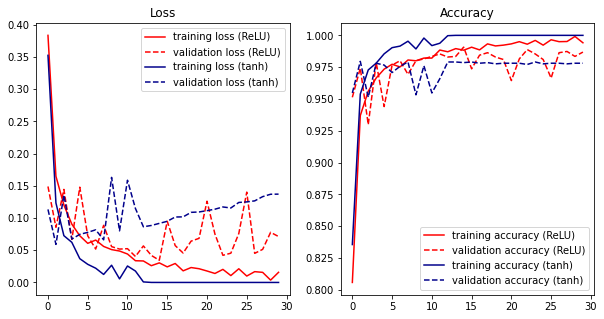

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'], color = 'red')
axs[0].plot(hist.epoch, hist.history['val_loss'], color = 'red', linestyle='dashed')
axs[0].plot(hist_compare.epoch, hist_compare.history['loss'], color = 'darkblue')
axs[0].plot(hist_compare.epoch, hist_compare.history['val_loss'], color = 'darkblue', linestyle='dashed')
axs[0].set_title("Loss")
axs[0].legend(('training loss (ReLU)', 
               'validation loss (ReLU)',
               'training loss (tanh)', 
               'validation loss (tanh)'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'], color = 'red')
axs[1].plot(hist.epoch, hist.history['val_accuracy'], color = 'red', linestyle='dashed')
axs[1].plot(hist_compare.epoch, hist_compare.history['accuracy'], color = 'darkblue')
axs[1].plot(hist_compare.epoch, hist_compare.history['val_accuracy'],  color = 'darkblue', linestyle='dashed')
axs[1].set_title("Accuracy")
axs[1].legend(('training accuracy (ReLU)', 
               'validation accuracy (ReLU)',
               'training accuracy (tanh)', 
               'validation accuracy (tanh)'), loc='lower right')
plt.show()

####Model 2
- 4 Convolutional Layers
- Batch size 10
- 30 epochs

Testing:
- Activation functions ReLU and tanh for hidden layers
- Stride in (2,3) Conv-Layer
- Filter in (2,3)
- Learing rate in (0.001, 0.0005)

Adaptions are made manually instead of a grid search.

In [ ]:
model = tf.keras.models.Sequential([
    # 1st Convolutional Layer strides = (2,2), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides = (2,2), activation ='relu', padding='same', input_shape=(256, 64, 1)),
    # 1st Pooling Layer
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 2nd Convolutional Layer strides = (2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides = (2,2), activation = 'relu', padding='same'),
    # 2nd Pooling Layer
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 3rd Convolutional Layer    
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides = (2,2), activation = 'relu', padding='same'),
    # 3rd Pooling Layer
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 4th Convolutional Layer    
    tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides = (2,2) ,activation = 'relu', padding='same'),
    # 4th Pooling Layer
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),            
    # Flatten Layer
    tf.keras.layers.Flatten(),
    # First Fully Connected Layer
    tf.keras.layers.Dense(units=512, activation= 'relu'),
    # Second Fully Connected Layer
    tf.keras.layers.Dense(units=2, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005,),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Best model
hist = model.fit(x_train, y_train, 
          epochs=30,
          batch_size=10, 
          validation_data=(x_valid, y_valid))

In [ ]:
# Model to comapte
hist_compare = model.fit(x_train, y_train, 
          epochs=30, 
          batch_size=10, 
          validation_data=(x_valid, y_valid))

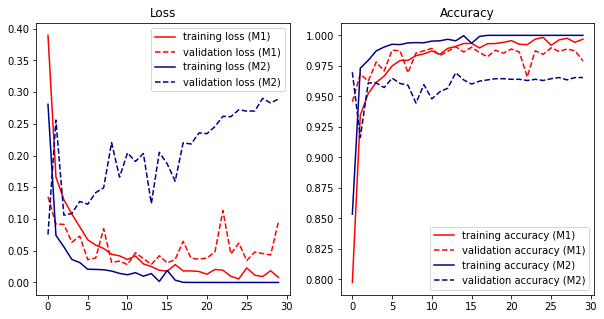

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'], color = 'red')
axs[0].plot(hist.epoch, hist.history['val_loss'], color = 'red', linestyle='dashed')
axs[0].plot(hist_compare.epoch, hist_compare.history['loss'], color = 'darkblue')
axs[0].plot(hist_compare.epoch, hist_compare.history['val_loss'], color = 'darkblue', linestyle='dashed')
axs[0].set_title("Loss")
axs[0].legend(('training loss (M1)', 
               'validation loss (M1)',
               'training loss (M2)', 
               'validation loss (M2)'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'], color = 'red')
axs[1].plot(hist.epoch, hist.history['val_accuracy'], color = 'red', linestyle='dashed')
axs[1].plot(hist_compare.epoch, hist_compare.history['accuracy'], color = 'darkblue')
axs[1].plot(hist_compare.epoch, hist_compare.history['val_accuracy'],  color = 'darkblue', linestyle='dashed')
axs[1].set_title("Accuracy")
axs[1].legend(('training accuracy (M1)', 
               'validation accuracy (M1)',
               'training accuracy (M2)', 
               'validation accuracy (M2)'), loc='lower right')
plt.show()

## FInal model and evaluation

In [ ]:
model = tf.keras.models.Sequential([
    # 1st Convolutional Layer strides = (2,2), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides = (2,2), activation ='relu', padding='same', input_shape=(256, 64, 1)),
    # 1st Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 2nd Convolutional Layer strides = (2,2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation = 'relu', padding='same'),
    # 2nd Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 3rd Convolutional Layer    
    tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation = 'relu', padding='same'),
    # 3rd Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    # 4th Convolutional Layer    
    tf.keras.layers.Conv2D(filters=256, kernel_size=2 ,activation = 'relu', padding='same'),
    # 4th Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),            
    # Flatten Layer
    tf.keras.layers.Flatten(),
    # First Fully Connected Layer
    tf.keras.layers.Dense(units=512, activation= 'relu'),
    # Second Fully Connected Layer
    tf.keras.layers.Dense(units=2, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005,),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Training and save of model to chose later the best one

save_path = 'save/sound_{epoch}.ckpt'

batch_size=10
n_itr_per_epoch = len(x_train) // batch_size
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                   save_weights_only=True,
                                                   save_freq= "epoch") # save every 1 epochs
hist = model.fit(x_train, y_train, 
          epochs=30, 
          batch_size=10, 
          validation_data=(x_valid, y_valid),
          callbacks=[save_callback])

22
0.9868549108505249


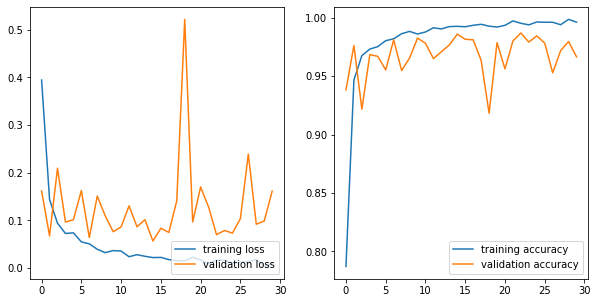

In [ ]:
print(hist.history['val_accuracy'].index(max((hist.history['val_accuracy']))))
print(max(hist.history['val_accuracy']))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [ ]:
# Load model with highest validation accuracy
model.load_weights('save/sound_23.ckpt')
loss, accuracy = model.evaluate(x_valid, y_valid)
print(accuracy)

65/65 [==============================] - 1s 10ms/step - loss: 0.0701 - accuracy: 0.9869
0.9868549108505249


In [ ]:
model.save('/content/MyDrive/Projekt/M6/model_weights_evaluation.h5')

In [ ]:
test_pred = model.predict(x_valid)
pred_class_idx = np.argmax(test_pred, axis=1)
# Genereate True / False array for validation set
correct = pred_class_idx == y_valid[:, 1]
correct
# 0 = Music
# 1 = Speech

65/65 [==============================] - 0s 4ms/step


In [ ]:
wrong_idx  = [i for i,c in enumerate(correct) if c == False]

In [ ]:
y_pred = model.predict(x_valid)
y_pred_labels = tf.argmax(y_pred, axis=1)
y_true = y_valid[:, 1]
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred_labels)
print(confusion_matrix)

65/65 [==============================] - 0s 4ms/step
tf.Tensor(
[[1015   12]
 [  15 1012]], shape=(2, 2), dtype=int32)


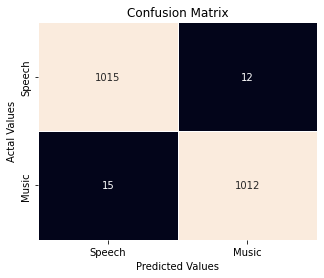

In [ ]:
cm_df = pd.DataFrame(confusion_matrix.numpy(),
                     index = ['Speech','Music'], 
                     columns = ['Speech','Music'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, linewidth=.5, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

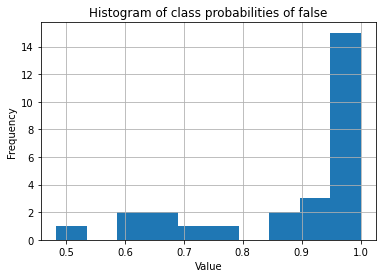

In [ ]:
# Find probabilties of false predicted
y_pred_prob = np.amax(y_pred, axis = 1)
wrong_probabilies = [y_pred_prob[i] for i in wrong_idx]

# Create a histogram with 10 bins
plt.hist(wrong_probabilies, bins=10)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid()
plt.title('Histogram of class probabilities of false')

# Show the plot
plt.show()

In [ ]:
# Select name of wrong predicted audio files
selected_items = [audio_name_valid[i] for i in wrong_idx]
print(len(selected_items))
selected_pahts = [audio_path_valid[i] for i in wrong_idx]
unique_items = set(selected_items)
print(len(unique_items))
cnt_path = Counter(selected_pahts)
Counter(selected_items)

27
8


Counter({'ncherry.wav': 4,
         'gravity.wav': 8,
         'voices.wav': 1,
         'nj105.wav': 2,
         'dialogue1.wav': 2,
         'nj105a.wav': 2,
         'dialogue.wav': 6,
         'my_voice.wav': 2})

In [ ]:
print(list(cnt_path.keys())[1])
Audio(list(cnt_path.keys())[1])

content/MyDrive/Projekt/M6/extract_files/Assignments/Speech_Music/speech_music_files/gtzan_music_speech/music_speech/music_wav/gravity.wav


(661500,)


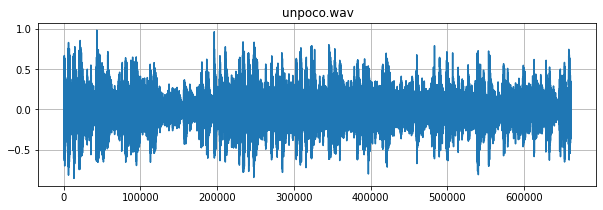

In [ ]:
music_file = music[5]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[127:])
plt.show()

(661500,)


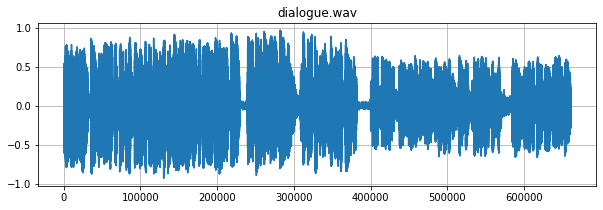

In [ ]:
music_file = list(cnt_path.keys())[-2]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[128:])
plt.show()

(661500,)


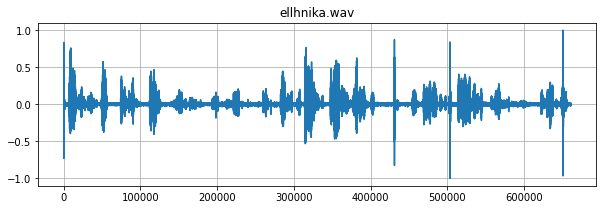

In [ ]:
music_file = speech[19]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[128:])
plt.show()

(661500,)


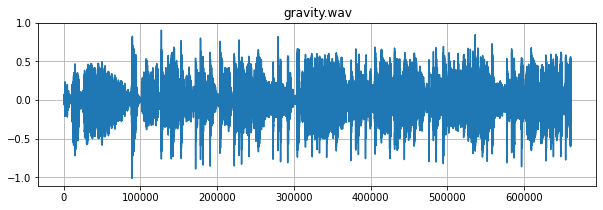

In [ ]:
music_file = list(cnt_path.keys())[1]
mus0 = load_wav(music_file)
print(mus0.shape)
plt.figure(figsize=(10, 3))
plt.plot(mus0)
plt.grid()
plt.title(music_file[127:])
plt.show()